In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks


import warnings
warnings.filterwarnings('ignore')

-------------------------------

# Prepare data 

In [2]:
#  Load the climate data

file_path = "Kalam Climate Data.xlsx"   
climate_df = pd.read_excel(file_path)

climate_df['Date Time'] = pd.to_datetime(climate_df['Date Time'])

# Extract date

climate_df['date'] = climate_df['Date Time'].dt.date

# Daily aggregation
daily_climate = climate_df.groupby('date').agg({
    'Temperature (°C)': ['mean', 'min', 'max'],
    'Dewpoint Temperature (°C)': ['mean', 'min', 'max'],
    'U Wind Component (m/s)': 'mean',
    'V Wind Component (m/s)': 'mean',
    'Total Precipitation (mm)': 'sum',
    'Snowfall (mm)': 'sum',
    'Snow Cover (%)': 'mean'
})

# Flatten columns
daily_climate.columns = ['_'.join(col).strip() for col in daily_climate.columns.values]

# Reset index
daily_climate = daily_climate.reset_index()

# Define start and end dates
start_date = pd.to_datetime('2024-09-24')
end_date   = pd.to_datetime('2024-10-24')

daily_climate["date"] = pd.to_datetime(daily_climate["date"])

# Filter DataFrame
extra_month_df = daily_climate[(daily_climate['date'] >= start_date) & (daily_climate['date'] <= end_date)]


new_names = {
    'date': 'Date',
    'Temperature (°C)_mean': 'Temp_Mean',
    'Temperature (°C)_min': 'Temp_Min',
    'Temperature (°C)_max': 'Temp_Max',
    'Dewpoint Temperature (°C)_mean': 'Dewpoint_Mean',
    'Dewpoint Temperature (°C)_min': 'Dewpoint_Min',
    'Dewpoint Temperature (°C)_max': 'Dewpoint_Max',
    'U Wind Component (m/s)_mean': 'U_Wind_Mean',
    'V Wind Component (m/s)_mean': 'V_Wind_Mean',
    'Total Precipitation (mm)_sum': 'Precipitation_Sum',
    'Snowfall (mm)_sum': 'Snowfall_Sum',
    'Snow Cover (%)_mean': 'SnowCover_Mean'
}


extra_month_df.rename(columns=new_names, inplace=True)

all_data_df = pd.read_csv("Data.csv")

all_data_df.drop(columns=["consumer_device_9", "consumer_device_x", "v_red", "v_blue","v_yellow", "current", "power_factor"], inplace=True)
all_data_df.head()

# Ensure datetime
all_data_df['date_time'] = pd.to_datetime(all_data_df['date_time'])


# Extract date (drop time)
all_data_df['date'] = all_data_df['date_time'].dt.date


# Group by Source (consumer_device + data_user) and date

daily_df = all_data_df.groupby(['Source', 'date']).agg({
    'kwh': 'sum'  
})

daily_df = daily_df.reset_index()


# Ensure datetime index
daily_df = daily_df.set_index("date").sort_index()
daily_climate = daily_climate.set_index("date").sort_index()

# Merge
merged_daily_df = daily_df.join(daily_climate, how="left")


merged_daily_df.reset_index(inplace=True)

merged_daily_df.to_csv("second_daily_merged_hydro_climate.csv", index=False)


# Dictionary mapping old names to new names
new_names = {
    'date': 'Date',
    'Source': 'Source',
    'kwh': 'kwh',
    'Temperature (°C)_mean': 'Temp_Mean',
    'Temperature (°C)_min': 'Temp_Min',
    'Temperature (°C)_max': 'Temp_Max',
    'Dewpoint Temperature (°C)_mean': 'Dewpoint_Mean',
    'Dewpoint Temperature (°C)_min': 'Dewpoint_Min',
    'Dewpoint Temperature (°C)_max': 'Dewpoint_Max',
    'U Wind Component (m/s)_mean': 'U_Wind_Mean',
    'V Wind Component (m/s)_mean': 'V_Wind_Mean',
    'Total Precipitation (mm)_sum': 'Precipitation_Sum',
    'Snowfall (mm)_sum': 'Snowfall_Sum',
    'Snow Cover (%)_mean': 'SnowCover_Mean'
}

merged_daily_df.rename(columns=new_names, inplace=True)

----------------------------------

# Let us train a Feed-Forward Neural Network (MLP)

# 1 st Approach: -----> Zindi Score 4.928191196 kWh

Feature Engineering 

In [3]:
def add_features(df):
    df = df.copy()
    df["Temp_dew_diff"] = df["Temp_Mean"] - df["Dewpoint_Mean"]
    df["wind_speed"] = np.sqrt(df["U_Wind_Mean"]**2 + df["V_Wind_Mean"]**2)
    df["precip_snow_ratio"] = df["Precipitation_Sum"] / (df["Snowfall_Sum"] + 1e-6)
    return df

def add_lag_roll(df, group_col="Source", target_col="kwh", lags=[1,2,7], windows=[3,7]):
    df = df.sort_values(["Source","Date"]).copy()
    for lag in lags:
        df[f"lag_{lag}"] = df.groupby(group_col)[target_col].shift(lag)
    for w in windows:
        df[f"roll_mean_{w}"] = df.groupby(group_col)[target_col].shift(1).rolling(w).mean()
    return df

In [4]:
# --- Reindex all Sources across full date range ---
def reindex_sources(df):
    all_dates = pd.date_range(df["Date"].min(), df["Date"].max())
    all_sources = df["Source"].unique()
    idx = pd.MultiIndex.from_product([all_sources, all_dates], names=["Source","Date"])
    df_full = df.set_index(["Source","Date"]).reindex(idx).reset_index()
    df_full["kwh"] = df_full["kwh"].fillna(0)
    climate_cols = [c for c in df.columns if c not in ["Source","kwh","Date"]]
    for c in climate_cols:
        df_full[c] = df_full.groupby("Date")[c].transform("first")
    return df_full


# --- Prepare dataset ---
df = merged_daily_df.copy()
df["Date"] = pd.to_datetime(df["Date"])
df = reindex_sources(df)
df = add_features(df)
df = add_lag_roll(df)
df = df.dropna().reset_index(drop=True)

feature_cols = [
    "Temp_Mean","Temp_Min","Temp_Max","Dewpoint_Mean","Dewpoint_Min","Dewpoint_Max",
    "U_Wind_Mean","V_Wind_Mean","Precipitation_Sum","Snowfall_Sum","SnowCover_Mean",
    "Temp_dew_diff","wind_speed","precip_snow_ratio",
] + [c for c in df.columns if c.startswith("lag_") or c.startswith("roll_")]

X = df[feature_cols].values
y = df["kwh"].values



# Scale features for neural net
scaler = StandardScaler()
X = scaler.fit_transform(X)




# Modeling

In [5]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Build MLP model ---
def create_mlp(input_dim):
    model = models.Sequential()
    model.add(layers.Dense(128, activation="relu", input_dim=input_dim))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dense(1, activation="relu"))  # relu ensures no negative kwh
    model.compile(optimizer="adam", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

mlp = create_mlp(X_train.shape[1])

# --- Callbacks: EarlyStopping + ReduceLROnPlateau ---
early_stop = callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True, verbose=0
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=0
)

history = mlp.fit(
    X_train, y_train,
    validation_data=(X_test,y_test),
    epochs=100, batch_size=256, verbose=0,
    callbacks=[early_stop, reduce_lr]
)

# Predict on test
y_pred = mlp.predict(X_test, verbose=0).flatten()
y_pred = np.maximum(0, y_pred)  # safety clip

# --- Global Metrics ---
print("=== Global Metrics ===")
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Regression: RMSE={rmse:.3f}, MAPE={mape:.3f}\n")

=== Global Metrics ===
Regression: RMSE=1.060, MAPE=38598875971874.023



# Predict next month (extra climate data) 

In [6]:

extra = add_features(extra_month_df.copy())
extra["Date"] = pd.to_datetime(extra["Date"])

preds = []
sources = df["Source"].unique()
for src in sources:
    hist = df[df["Source"]==src].copy()
    extra_src = extra.copy()
    extra_src["Source"] = src
    lag_hist = hist.tail(7).reset_index(drop=True)
    rows = []
    for _, row in extra_src.iterrows():
        r = row.to_dict()
        for lag in [1,2,7]:
            if len(lag_hist) >= lag:
                r[f"lag_{lag}"] = lag_hist.loc[len(lag_hist)-lag,"kwh"]
            else:
                r[f"lag_{lag}"] = np.nan
        for w in [3,7]:
            if len(lag_hist) >= w:
                r[f"roll_mean_{w}"] = lag_hist["kwh"].iloc[-w:].mean()
            else:
                r[f"roll_mean_{w}"] = lag_hist["kwh"].mean()
        X_ex = pd.DataFrame([r])[feature_cols].fillna(0)
        X_ex = scaler.transform(X_ex)
        r["pred_kwh"] = max(0, mlp.predict(X_ex, verbose=0)[0,0])
        lag_hist = pd.concat([lag_hist, pd.DataFrame([{"kwh": r["pred_kwh"]}])], ignore_index=True)
        rows.append(r)
    preds.append(pd.DataFrame(rows))
preds_df = pd.concat(preds)


# Plots

In [7]:
"""
# Per Source

def plot_source(src):
    plt.figure(figsize=(12,4))
    d = df[df["Source"]==src]
    plt.plot(d["Date"], d["kwh"], label="actual")
    d_extra = preds_df[preds_df["Source"]==src]
    plt.plot(d_extra["Date"], d_extra["pred_kwh"], "--", label="pred (extra month)")
    plt.title(f"Source {src}")
    plt.legend()
    plt.show()

for src in sources:
    plot_source(src)

"""

'\n# Per Source\n\ndef plot_source(src):\n    plt.figure(figsize=(12,4))\n    d = df[df["Source"]==src]\n    plt.plot(d["Date"], d["kwh"], label="actual")\n    d_extra = preds_df[preds_df["Source"]==src]\n    plt.plot(d_extra["Date"], d_extra["pred_kwh"], "--", label="pred (extra month)")\n    plt.title(f"Source {src}")\n    plt.legend()\n    plt.show()\n\nfor src in sources:\n    plot_source(src)\n\n'

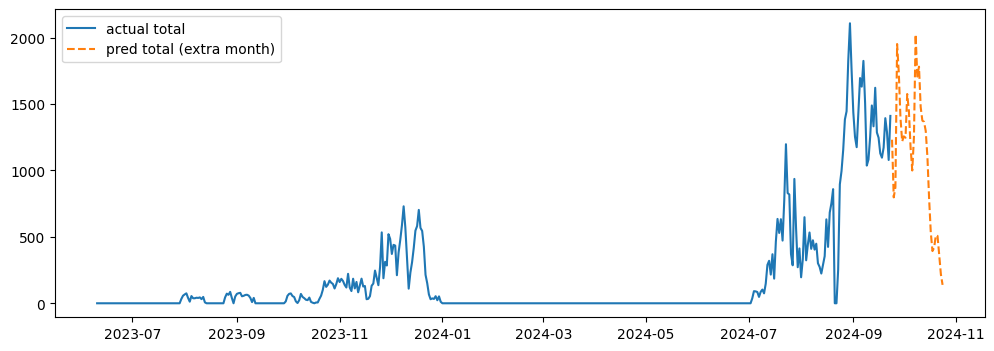

In [8]:
# Overall 

plt.figure(figsize=(12,4))
plt.plot(df.groupby("Date")["kwh"].sum(), label="actual total")
plt.plot(preds_df.groupby("Date")["pred_kwh"].sum(), "--", label="pred total (extra month)")
plt.legend()
plt.show()

# Build Submission file for Zindi

In [9]:
sub = pd.read_csv("SampleSubmission.csv")
sub["Date"] = sub["ID"].apply(lambda x: x.split("_")[0])
sub["Source"] = sub["ID"].apply(lambda x: "_".join(x.split("_")[1:]))
sub["Date"] = pd.to_datetime(sub["Date"])

preds_out = preds_df.copy()
preds_out["Date"] = pd.to_datetime(preds_out["Date"])

submission = sub.merge(preds_out[["Date","Source","pred_kwh"]], on=["Date","Source"], how="left")
submission = submission[["ID","pred_kwh"]]

submission.to_csv("MySubmission_3_MLP.csv", index=False)
submission

,ID,pred_kwh
0,2024-09-24_consumer_device_12_data_user_1,0.0
1,2024-09-25_consumer_device_12_data_user_1,0.0
2,2024-09-26_consumer_device_12_data_user_1,0.0
3,2024-09-27_consumer_device_12_data_user_1,0.0
4,2024-09-28_consumer_device_12_data_user_1,0.0
...,...,...
6009,2024-10-20_consumer_device_8_data_user_9,0.0
6010,2024-10-21_consumer_device_8_data_user_9,0.0
6011,2024-10-22_consumer_device_8_data_user_9,0.0
6012,2024-10-23_consumer_device_8_data_user_9,0.0


-------------------------

# Second Approach:   performed worse ----> Zindi 6.431916951

1) Add calendar features + longer rolling windows:

- Calendar features (day_of_week, month, is_weekend, season)

- Longer rolling windows (14 and 30 days)

- Exponential moving average (EMA) features

2) Added Dropout (0.2) layers for better generalization.

3) Extended lag history to 30 days when predicting extra month.

In [10]:


# Feature Engineering 


def add_features(df):
    df = df.copy()
    # Climate derived features
    df["Temp_dew_diff"] = df["Temp_Mean"] - df["Dewpoint_Mean"]
    df["wind_speed"] = np.sqrt(df["U_Wind_Mean"]**2 + df["V_Wind_Mean"]**2)
    df["precip_snow_ratio"] = df["Precipitation_Sum"] / (df["Snowfall_Sum"] + 1e-6)
    
    # Calendar features
    df["day_of_week"] = df["Date"].dt.dayofweek
    df["month"] = df["Date"].dt.month
    df["is_weekend"] = (df["day_of_week"] >= 5).astype(int)
    # Simple season encoding (1–4)
    df["season"] = ((df["month"] % 12 + 3) // 3)
    
    return df


def add_lag_roll(df, group_col="Source", target_col="kwh", lags=[1,2,7], windows=[3,7,14,30]):
    df = df.sort_values([group_col,"Date"]).copy()
    # Lags
    for lag in lags:
        df[f"lag_{lag}"] = df.groupby(group_col)[target_col].shift(lag)
    # Rolling means
    for w in windows:
        df[f"roll_mean_{w}"] = df.groupby(group_col)[target_col].shift(1).rolling(w).mean()
    # Exponential moving averages
    for span in [7,14,30]:
        df[f"ema_{span}"] = df.groupby(group_col)[target_col].shift(1).ewm(span=span, adjust=False).mean()
    return df


def add_source_stats(df, group_col="Source", target_col="kwh"):
    stats = df.groupby(group_col)[target_col].agg(["mean","median"]).reset_index()
    stats.columns = [group_col, "src_mean_kwh", "src_median_kwh"]
    df = df.merge(stats, on=group_col, how="left")
    return df


def reindex_sources(df):
    all_dates = pd.date_range(df["Date"].min(), df["Date"].max())
    all_sources = df["Source"].unique()
    idx = pd.MultiIndex.from_product([all_sources, all_dates], names=["Source","Date"])
    df_full = df.set_index(["Source","Date"]).reindex(idx).reset_index()
    df_full["kwh"] = df_full["kwh"].fillna(0)
    climate_cols = [c for c in df.columns if c not in ["Source","kwh","Date"]]
    for c in climate_cols:
        df_full[c] = df_full.groupby("Date")[c].transform("first")
    return df_full



#  Prepare dataset 


df = merged_daily_df.copy()
df["Date"] = pd.to_datetime(df["Date"])
df = reindex_sources(df)
df = add_features(df)
df = add_lag_roll(df)
df = add_source_stats(df)
df = df.dropna().reset_index(drop=True)

# Features
feature_cols = [
    "Temp_Mean","Temp_Min","Temp_Max","Dewpoint_Mean","Dewpoint_Min","Dewpoint_Max",
    "U_Wind_Mean","V_Wind_Mean","Precipitation_Sum","Snowfall_Sum","SnowCover_Mean",
    "Temp_dew_diff","wind_speed","precip_snow_ratio",
    "day_of_week","month","is_weekend","season",
    "src_mean_kwh","src_median_kwh"
] + [c for c in df.columns if c.startswith("lag_") or c.startswith("roll_") or c.startswith("ema_")]

X = df[feature_cols].values
y = df["kwh"].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#  Build MLP model 


def create_mlp(input_dim):
    model = models.Sequential()
    model.add(layers.Dense(128, activation="relu", input_dim=input_dim))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dense(1, activation="relu"))                                                         # Here relu ensures no negative predictions, NO NEED TO WORRY ABOUT IT !
    model.compile(optimizer="adam", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

mlp = create_mlp(X_train.shape[1])

early_stop = callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True, verbose=0
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=0
)

history = mlp.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100, batch_size=256, verbose=0,
    callbacks=[early_stop, reduce_lr]
)


#  Evaluate on test set 

y_pred = mlp.predict(X_test, verbose=0).flatten()
y_pred = np.maximum(0, y_pred)

print("=== Global Metrics ===")
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Regression: RMSE={rmse:.3f}, MAPE={mape:.3f}\n")




=== Global Metrics ===
Regression: RMSE=1.082, MAPE=61006882213377.109



In [11]:

#  Predict extra month 

extra = add_features(extra_month_df.copy())
extra["Date"] = pd.to_datetime(extra["Date"])

preds = []
sources = df["Source"].unique()
for src in sources:
    hist = df[df["Source"]==src].copy()
    extra_src = extra.copy()
    extra_src["Source"] = src
    lag_hist = hist.tail(30).reset_index(drop=True)  # keep last 30 days
    rows = []
    for _, row in extra_src.iterrows():
        r = row.to_dict()
        # Lags
        for lag in [1,2,7]:
            if len(lag_hist) >= lag:
                r[f"lag_{lag}"] = lag_hist.loc[len(lag_hist)-lag, "kwh"]
            else:
                r[f"lag_{lag}"] = 0
        # Rolling means
        for w in [3,7,14,30]:
            if len(lag_hist) >= w:
                r[f"roll_mean_{w}"] = lag_hist["kwh"].iloc[-w:].mean()
            else:
                r[f"roll_mean_{w}"] = lag_hist["kwh"].mean()
        # EMA
        for span in [7,14,30]:
            r[f"ema_{span}"] = lag_hist["kwh"].ewm(span=span, adjust=False).mean().iloc[-1]
        # Source stats
        r["src_mean_kwh"] = hist["kwh"].mean()
        r["src_median_kwh"] = hist["kwh"].median()
        # Predict
        X_ex = pd.DataFrame([r])[feature_cols].fillna(0)
        X_ex = scaler.transform(X_ex)
        r["pred_kwh"] = max(0, mlp.predict(X_ex, verbose=0)[0,0])
        lag_hist = pd.concat([lag_hist, pd.DataFrame([{"kwh": r["pred_kwh"]}])], ignore_index=True)
        rows.append(r)
    preds.append(pd.DataFrame(rows))
preds_df = pd.concat(preds)



In [12]:

# Prepare submission 

sub = pd.read_csv("SampleSubmission.csv")
sub["Date"] = sub["ID"].apply(lambda x: x.split("_")[0])
sub["Source"] = sub["ID"].apply(lambda x: "_".join(x.split("_")[1:]))
sub["Date"] = pd.to_datetime(sub["Date"])

preds_out = preds_df.copy()
preds_out["Date"] = pd.to_datetime(preds_out["Date"])

submission = sub.merge(preds_out[["Date","Source","pred_kwh"]], on=["Date","Source"], how="left")
submission = submission[["ID","pred_kwh"]]
submission.to_csv("MySubmission_5_MLP.csv", index=False)

-------------------------------

# Third approach -----> zindi 4.50048738  (4th Position !!)

Let us not apply all the changes together, but one by one. Let us try first only adding the drop out layers

=== Global Metrics ===
Regression: RMSE=1.2413, MAPE=57389186889681.1641

Per-source TEST sample (first rows):
                         Source     RMSE         MAPE  N_test_rows
 consumer_device_10_data_user_1 1.509849 8.088182e-01           97
consumer_device_10_data_user_10 2.227678 7.809626e+13           93
consumer_device_10_data_user_11 1.315007 2.799455e+14          111
consumer_device_10_data_user_12 0.901120 2.785113e+13          109
consumer_device_10_data_user_13 0.488954 2.899950e+13           94
consumer_device_10_data_user_14 0.640131 1.856821e+14           90
consumer_device_10_data_user_15 0.945175 7.205704e-02           94
consumer_device_10_data_user_16 0.028818 8.602151e-02           93
consumer_device_10_data_user_17 0.011261 1.517857e-01          112
consumer_device_10_data_user_18 0.039920 1.176471e-01           85


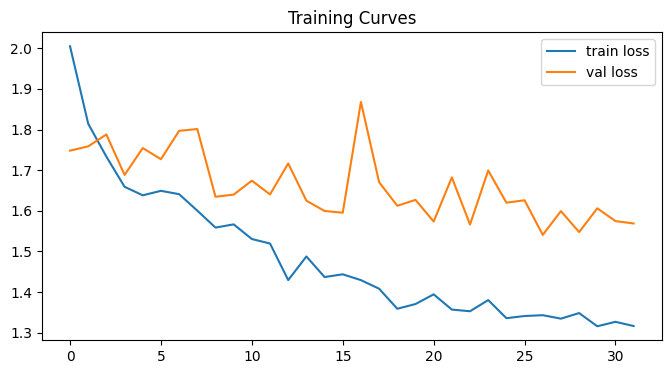

In [13]:
# Feature engineering (unchanged)

def add_features(df):
    df = df.copy()
    df["Temp_dew_diff"] = df["Temp_Mean"] - df["Dewpoint_Mean"]
    df["wind_speed"] = np.sqrt(df["U_Wind_Mean"]**2 + df["V_Wind_Mean"]**2)
    df["precip_snow_ratio"] = df["Precipitation_Sum"] / (df["Snowfall_Sum"] + 1e-6)
    return df

def add_lag_roll(df, group_col="Source", target_col="kwh", lags=[1,2,7], windows=[3,7]):
    df = df.sort_values([group_col,"Date"]).copy()
    for lag in lags:
        df[f"lag_{lag}"] = df.groupby(group_col)[target_col].shift(lag)
    for w in windows:
        df[f"roll_mean_{w}"] = df.groupby(group_col)[target_col].shift(1).rolling(w).mean()
    return df

def reindex_sources(df):
    all_dates = pd.date_range(df["Date"].min(), df["Date"].max())
    all_sources = df["Source"].unique()
    idx = pd.MultiIndex.from_product([all_sources, all_dates], names=["Source","Date"])
    df_full = df.set_index(["Source","Date"]).reindex(idx).reset_index()
    df_full["kwh"] = df_full["kwh"].fillna(0)
    climate_cols = [c for c in df.columns if c not in ["Source","kwh","Date"]]
    for c in climate_cols:
        df_full[c] = df_full.groupby("Date")[c].transform("first")
    return df_full


# Prepare dataset

df = merged_daily_df.copy()
df["Date"] = pd.to_datetime(df["Date"])
df = reindex_sources(df)                
df = add_features(df)
df = add_lag_roll(df)
df = df.dropna().reset_index(drop=True) 

feature_cols = [
    "Temp_Mean","Temp_Min","Temp_Max","Dewpoint_Mean","Dewpoint_Min","Dewpoint_Max",
    "U_Wind_Mean","V_Wind_Mean","Precipitation_Sum","Snowfall_Sum","SnowCover_Mean",
    "Temp_dew_diff","wind_speed","precip_snow_ratio",
] + [c for c in df.columns if c.startswith("lag_") or c.startswith("roll_")]

# train/test split 
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

# scale features for MLP
scaler = StandardScaler()
X_train = scaler.fit_transform(train_df[feature_cols])
y_train = train_df["kwh"].values
X_test = scaler.transform(test_df[feature_cols])
y_test = test_df["kwh"].values

# -------------------------
# MLP model (only addition: Dropout) !!
# -------------------------
def create_mlp_with_dropout(input_dim):
    model = models.Sequential()
    model.add(layers.Dense(128, activation="relu", input_dim=input_dim))
    model.add(layers.Dropout(0.2))            # <-- added dropout
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(0.2))            # <-- added dropout
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dense(1, activation="relu"))  # ReLU to avoid negative predictions
    model.compile(optimizer="adam", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

mlp = create_mlp_with_dropout(X_train.shape[1])

early_stop = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=0)
reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=0)

history = mlp.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100, batch_size=256, verbose=0,
    callbacks=[early_stop, reduce_lr]
)


# Evaluate on test set

y_pred = mlp.predict(X_test, verbose=0).flatten()
y_pred = np.maximum(0, y_pred)   

print("=== Global Metrics ===")
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Regression: RMSE={rmse:.4f}, MAPE={mape:.4f}\n")

# per-source metrics on TEST (helpful to compare!)
per_source = []
for src in sorted(df["Source"].unique()):
    t_src = test_df[test_df["Source"] == src]
    if t_src.shape[0] == 0:
        continue
    # build X for this source in test_df order
    X_src = scaler.transform(t_src[feature_cols])
    y_src = t_src["kwh"].values
    y_src_pred = np.maximum(0, mlp.predict(X_src, verbose=0).flatten())
    rm = mean_squared_error(y_src, y_src_pred, squared=False)
    mp = mean_absolute_percentage_error(y_src, y_src_pred)
    per_source.append((src, rm, mp, len(t_src)))
per_source_df = pd.DataFrame(per_source, columns=["Source","RMSE","MAPE","N_test_rows"])
print("Per-source TEST sample (first rows):")
print(per_source_df.head(10).to_string(index=False))

# Let us see the training curves
plt.figure(figsize=(8,4))
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend(); plt.title("Training Curves"); plt.show()



In [14]:

# Extra-month predictions 

extra = add_features(extra_month_df.copy())
extra["Date"] = pd.to_datetime(extra["Date"])

preds = []
sources = df["Source"].unique()
for src in sources:
    hist = df[df["Source"]==src].copy()
    extra_src = extra.copy()
    extra_src["Source"] = src
    lag_hist = hist.tail(7).reset_index(drop=True)  # last 7 days to compute lags/rolls
    rows = []
    for _, row in extra_src.iterrows():
        r = row.to_dict()
        # lags
        for lag in [1,2,7]:
            if len(lag_hist) >= lag:
                r[f"lag_{lag}"] = lag_hist.loc[len(lag_hist)-lag, "kwh"]
            else:
                r[f"lag_{lag}"] = 0
        # rolling means
        for w in [3,7]:
            if len(lag_hist) >= w:
                r[f"roll_mean_{w}"] = lag_hist["kwh"].iloc[-w:].mean()
            else:
                r[f"roll_mean_{w}"] = lag_hist["kwh"].mean() if len(lag_hist)>0 else 0
        # predict
        X_ex = pd.DataFrame([r])[feature_cols].fillna(0)
        X_ex = scaler.transform(X_ex)
        r["pred_kwh"] = float(max(0, mlp.predict(X_ex, verbose=0)[0,0]))
        # append to history so next day uses predicted values as lags
        lag_hist = pd.concat([lag_hist, pd.DataFrame([{"kwh": r["pred_kwh"]}])], ignore_index=True)
        rows.append(r)
    preds.append(pd.DataFrame(rows))
preds_df = pd.concat(preds, ignore_index=True)




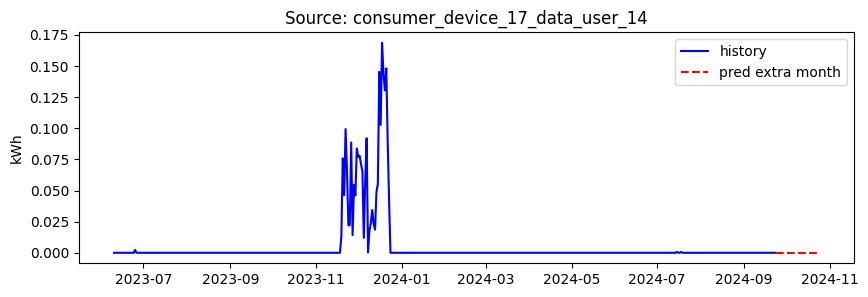

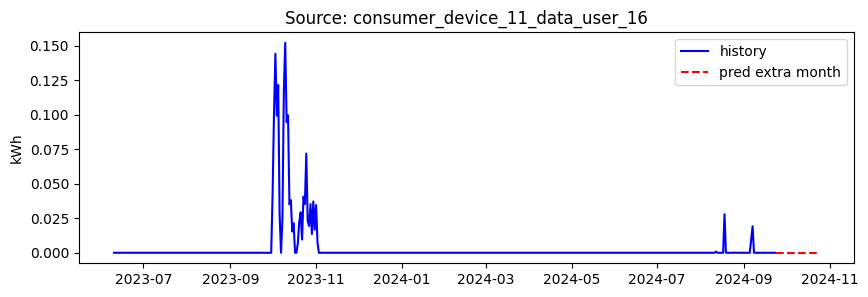

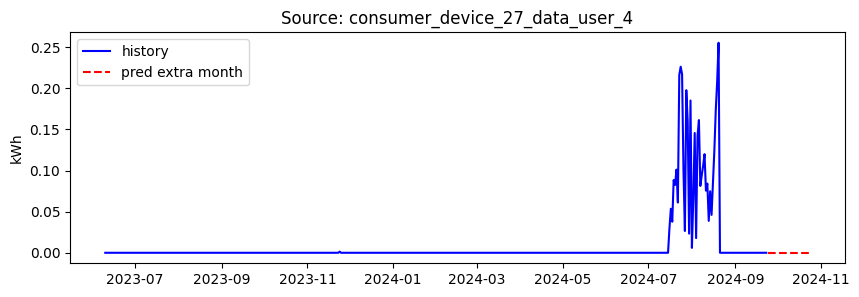

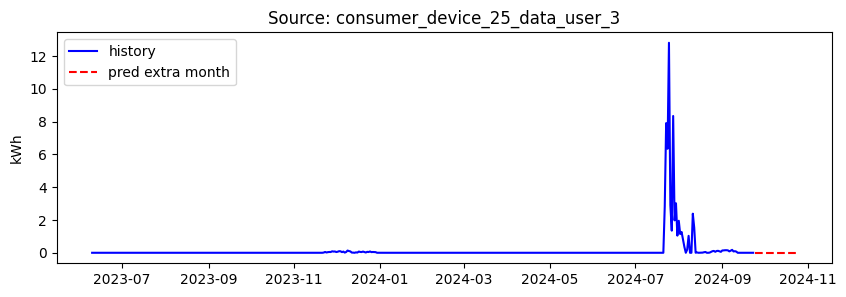

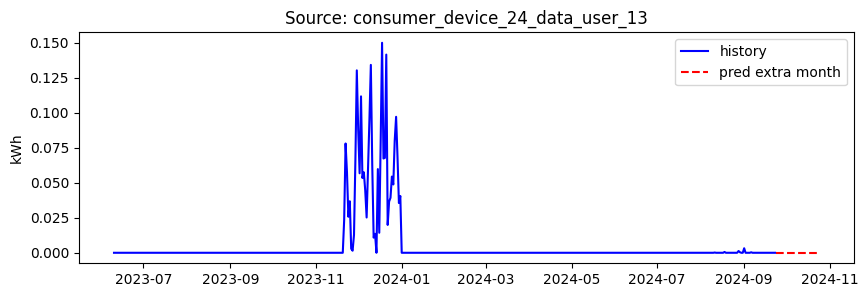

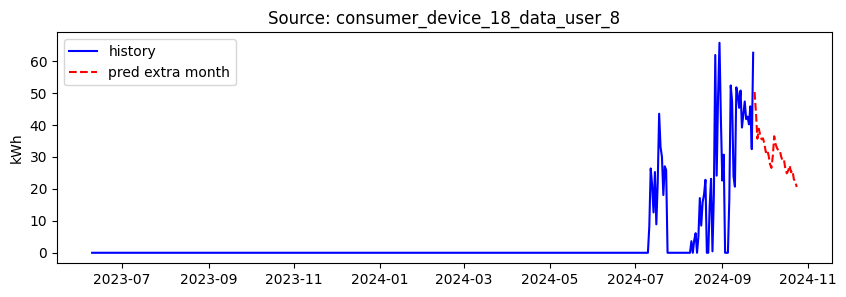

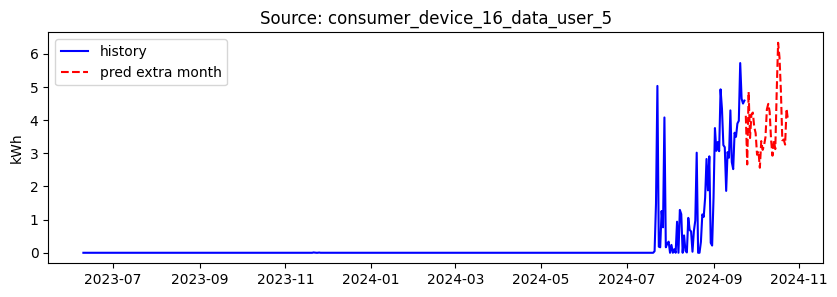

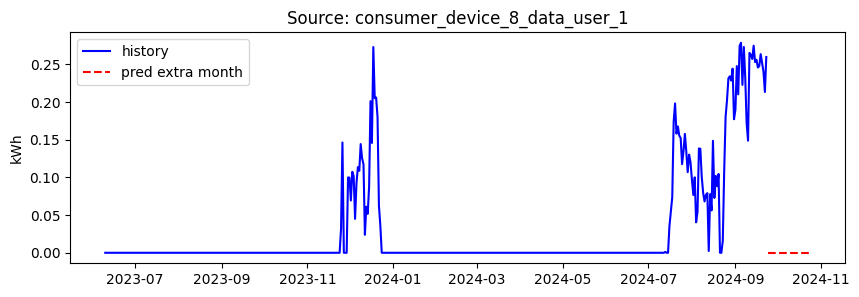

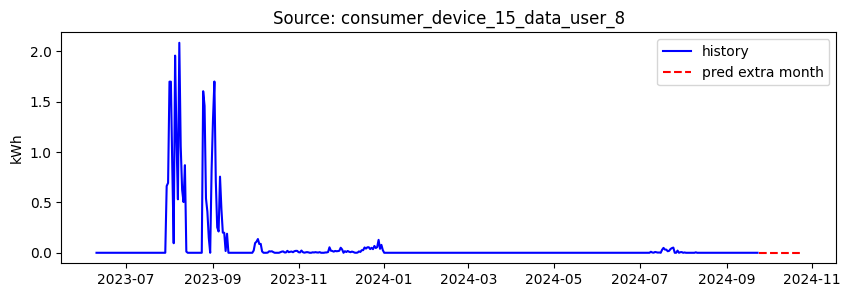

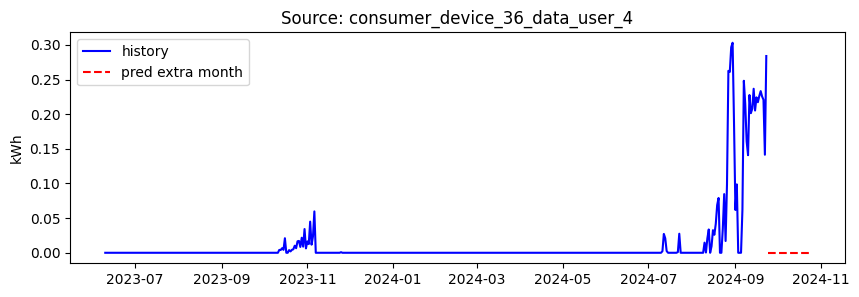

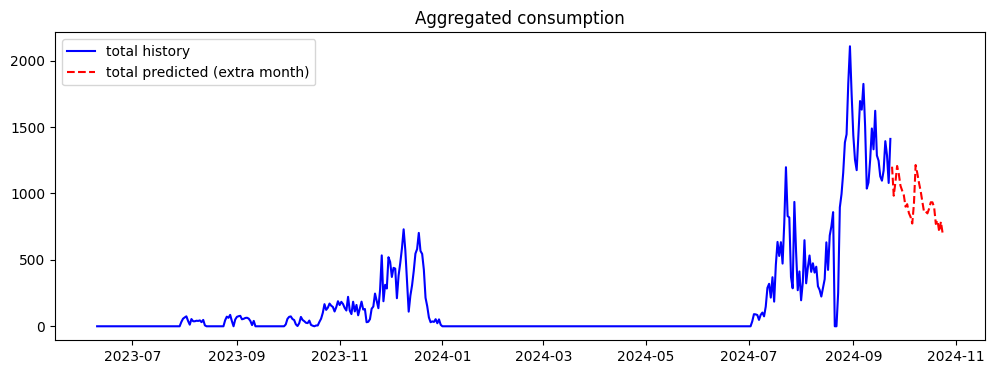

In [15]:
# Diagnostic plots (10 random sources + aggregated)

random.seed(42)
sample_sources = random.sample(list(df["Source"].unique()), min(10, len(df["Source"].unique())))

for src in sample_sources:
    g_true = df[df["Source"] == src].sort_values("Date")
    g_pred = preds_df[preds_df["Source"] == src].sort_values("Date")
    plt.figure(figsize=(10,3))
    plt.plot(g_true["Date"], g_true["kwh"], label="history", color="blue")
    plt.plot(g_pred["Date"], g_pred["pred_kwh"], "--", label="pred extra month", color="red")
    plt.title(f"Source: {src}")
    plt.ylabel("kWh"); plt.legend(); plt.show()

agg_true = df.groupby("Date")["kwh"].sum().reset_index()
agg_pred = preds_df.groupby("Date")["pred_kwh"].sum().reset_index()
plt.figure(figsize=(12,4))
plt.plot(agg_true["Date"], agg_true["kwh"], label="total history", color="blue")
plt.plot(agg_pred["Date"], agg_pred["pred_kwh"], "--", label="total predicted (extra month)", color="red")
plt.legend(); plt.title("Aggregated consumption"); plt.show()


In [16]:
# Prepare submission 

sub = pd.read_csv("SampleSubmission.csv")
sub["Date"] = sub["ID"].apply(lambda x: x.split("_")[0])
sub["Source"] = sub["ID"].apply(lambda x: "_".join(x.split("_")[1:]))
sub["Date"] = pd.to_datetime(sub["Date"])

preds_out = preds_df.copy()
preds_out["Date"] = pd.to_datetime(preds_out["Date"])

submission = sub.merge(preds_out[["Date","Source","pred_kwh"]], on=["Date","Source"], how="left")
submission = submission[["ID","pred_kwh"]]
submission.to_csv("MySubmission_6_MLP.csv", index=False)

--------------------------------

# Fourth Approach: -------> Zindi 4.48370432   (2nd Place)

Let’s add just one longer lag (lag_14) and one longer rolling window (roll_mean_14)

In [17]:


# --- Feature Engineering ---
def add_features(df):
    df = df.copy()
    df["Temp_dew_diff"] = df["Temp_Mean"] - df["Dewpoint_Mean"]
    df["wind_speed"] = np.sqrt(df["U_Wind_Mean"]**2 + df["V_Wind_Mean"]**2)
    df["precip_snow_ratio"] = df["Precipitation_Sum"] / (df["Snowfall_Sum"] + 1e-6)
    return df

def add_lag_roll(df, group_col="Source", target_col="kwh", lags=[1,2,7,14], windows=[3,7,14]):
    df = df.sort_values(["Source","Date"]).copy()
    for lag in lags:
        df[f"lag_{lag}"] = df.groupby(group_col)[target_col].shift(lag)
    for w in windows:
        df[f"roll_mean_{w}"] = df.groupby(group_col)[target_col].shift(1).rolling(w).mean()
    return df

# --- Step 1: Reindex all Sources across full date range ---
def reindex_sources(df):
    all_dates = pd.date_range(df["Date"].min(), df["Date"].max())
    all_sources = df["Source"].unique()
    idx = pd.MultiIndex.from_product([all_sources, all_dates], names=["Source","Date"])
    df_full = df.set_index(["Source","Date"]).reindex(idx).reset_index()
    df_full["kwh"] = df_full["kwh"].fillna(0)
    climate_cols = [c for c in df.columns if c not in ["Source","kwh","Date"]]
    for c in climate_cols:
        df_full[c] = df_full.groupby("Date")[c].transform("first")
    return df_full

# --- Prepare dataset ---
df = merged_daily_df.copy()
df["Date"] = pd.to_datetime(df["Date"])
df = reindex_sources(df)
df = add_features(df)
df = add_lag_roll(df)
df = df.dropna().reset_index(drop=True)

feature_cols = [
    "Temp_Mean","Temp_Min","Temp_Max","Dewpoint_Mean","Dewpoint_Min","Dewpoint_Max",
    "U_Wind_Mean","V_Wind_Mean","Precipitation_Sum","Snowfall_Sum","SnowCover_Mean",
    "Temp_dew_diff","wind_speed","precip_snow_ratio",
] + [c for c in df.columns if c.startswith("lag_") or c.startswith("roll_")]

X = df[feature_cols].values
y = df["kwh"].values

# Scale features for neural net
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Build MLP model ---
def create_mlp(input_dim):
    model = models.Sequential()
    model.add(layers.Dense(128, activation="relu", input_dim=input_dim))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dense(1, activation="relu"))  # relu ensures no negative kwh
    model.compile(optimizer="adam", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

mlp = create_mlp(X_train.shape[1])

# --- Callbacks: EarlyStopping + ReduceLROnPlateau ---
early_stop = callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True, verbose=0
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=0
)

history = mlp.fit(
    X_train, y_train,
    validation_data=(X_test,y_test),
    epochs=100, batch_size=256, verbose=0,
    callbacks=[early_stop, reduce_lr]
)

# Predict on test
y_pred = mlp.predict(X_test, verbose=0).flatten()
y_pred = np.maximum(0, y_pred)  # safety clip

# --- Global Metrics ---
print("=== Global Metrics ===")
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Regression: RMSE={rmse:.3f}, MAPE={mape:.3f}\n")

# --- Predict next month (extra data) ---
extra = add_features(extra_month_df.copy())
extra["Date"] = pd.to_datetime(extra["Date"])

preds = []
sources = df["Source"].unique()
for src in sources:
    hist = df[df["Source"]==src].copy()
    extra_src = extra.copy()
    extra_src["Source"] = src
    lag_hist = hist.tail(14).reset_index(drop=True)  # store enough history for lag_14
    rows = []
    for _, row in extra_src.iterrows():
        r = row.to_dict()
        for lag in [1,2,7,14]:
            if len(lag_hist) >= lag:
                r[f"lag_{lag}"] = lag_hist.loc[len(lag_hist)-lag,"kwh"]
            else:
                r[f"lag_{lag}"] = np.nan
        for w in [3,7,14]:
            if len(lag_hist) >= w:
                r[f"roll_mean_{w}"] = lag_hist["kwh"].iloc[-w:].mean()
            else:
                r[f"roll_mean_{w}"] = lag_hist["kwh"].mean()
        X_ex = pd.DataFrame([r])[feature_cols].fillna(0)
        X_ex = scaler.transform(X_ex)
        r["pred_kwh"] = max(0, mlp.predict(X_ex, verbose=0)[0,0])
        lag_hist = pd.concat([lag_hist, pd.DataFrame([{"kwh": r["pred_kwh"]}])], ignore_index=True)
        rows.append(r)
    preds.append(pd.DataFrame(rows))
preds_df = pd.concat(preds)



sub = pd.read_csv("SampleSubmission.csv")
sub["Date"] = sub["ID"].apply(lambda x: x.split("_")[0])
sub["Source"] = sub["ID"].apply(lambda x: "_".join(x.split("_")[1:]))
sub["Date"] = pd.to_datetime(sub["Date"])

preds_out = preds_df.copy()
preds_out["Date"] = pd.to_datetime(preds_out["Date"])

submission = sub.merge(preds_out[["Date","Source","pred_kwh"]], on=["Date","Source"], how="left")
submission = submission[["ID","pred_kwh"]]
submission.to_csv("MySubmission_7_MLP.csv", index=False)


=== Global Metrics ===
Regression: RMSE=1.061, MAPE=50481005302693.516



In [18]:
# Predict on test
y_pred_train = mlp.predict(X_train, verbose=0).flatten()
y_pred_train = np.maximum(0, y_pred_train)  # safety clip

# --- Global Metrics ---
print("=== Global Metrics ===")
rmse = mean_squared_error(y_train, y_pred_train, squared=False)

print(f"Regression: RMSE train={rmse:.3f}")

=== Global Metrics ===
Regression: RMSE train=0.956


-----------------

-----------------------------------------

# 5th Approach:  Huber loss instead of MSE ------> Zindi 4.390272303 1st Place !

- RMSE punishes big spikes a lot → in our data (zeros + bursts), that can dominate training.

- Huber loss is a mix: it acts like MSE for small errors, and like MAE for large errors.



In [19]:
# --- Feature Engineering ---
def add_features(df):
    df = df.copy()
    df["Temp_dew_diff"] = df["Temp_Mean"] - df["Dewpoint_Mean"]
    df["wind_speed"] = np.sqrt(df["U_Wind_Mean"]**2 + df["V_Wind_Mean"]**2)
    df["precip_snow_ratio"] = df["Precipitation_Sum"] / (df["Snowfall_Sum"] + 1e-6)
    return df

def add_lag_roll(df, group_col="Source", target_col="kwh", lags=[1,2,7,14], windows=[3,7,14]):
    df = df.sort_values(["Source","Date"]).copy()
    for lag in lags:
        df[f"lag_{lag}"] = df.groupby(group_col)[target_col].shift(lag)
    for w in windows:
        df[f"roll_mean_{w}"] = df.groupby(group_col)[target_col].shift(1).rolling(w).mean()
    return df

# --- Step 1: Reindex all Sources across full date range ---
def reindex_sources(df):
    all_dates = pd.date_range(df["Date"].min(), df["Date"].max())
    all_sources = df["Source"].unique()
    idx = pd.MultiIndex.from_product([all_sources, all_dates], names=["Source","Date"])
    df_full = df.set_index(["Source","Date"]).reindex(idx).reset_index()
    df_full["kwh"] = df_full["kwh"].fillna(0)
    climate_cols = [c for c in df.columns if c not in ["Source","kwh","Date"]]
    for c in climate_cols:
        df_full[c] = df_full.groupby("Date")[c].transform("first")
    return df_full

# --- Prepare dataset ---
df = merged_daily_df.copy()
df["Date"] = pd.to_datetime(df["Date"])
df = reindex_sources(df)
df = add_features(df)
df = add_lag_roll(df)
df = df.dropna().reset_index(drop=True)

feature_cols = [
    "Temp_Mean","Temp_Min","Temp_Max","Dewpoint_Mean","Dewpoint_Min","Dewpoint_Max",
    "U_Wind_Mean","V_Wind_Mean","Precipitation_Sum","Snowfall_Sum","SnowCover_Mean",
    "Temp_dew_diff","wind_speed","precip_snow_ratio",
] + [c for c in df.columns if c.startswith("lag_") or c.startswith("roll_")]

X = df[feature_cols].values
y = df["kwh"].values

# Scale features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Build MLP model (no BN, just Dropout) ---
def create_mlp(input_dim):
    model = models.Sequential()
    model.add(layers.Dense(128, activation="relu", input_dim=input_dim))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dense(1, activation="relu"))  # ensures no negative kwh
    
    # 👇 Huber loss instead of MSE
    model.compile(optimizer="adam", loss=tf.keras.losses.Huber(), metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

mlp = create_mlp(X_train.shape[1])

# --- Callbacks ---
early_stop = callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True, verbose=0
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=0
)

# --- Train ---
history = mlp.fit(
    X_train, y_train,
    validation_data=(X_test,y_test),
    epochs=100, batch_size=256, verbose=0,
    callbacks=[early_stop, reduce_lr]
)

# --- Predict on test ---
y_pred = mlp.predict(X_test, verbose=0).flatten()
y_pred = np.maximum(0, y_pred)

rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MLP + Huber: RMSE={rmse:.3f}, MAPE={mape:.3f}")

# --- Predict next month (extra data) ---
extra = add_features(extra_month_df.copy())
extra["Date"] = pd.to_datetime(extra["Date"])

preds = []
sources = df["Source"].unique()
for src in sources:
    hist = df[df["Source"]==src].copy()
    extra_src = extra.copy()
    extra_src["Source"] = src
    lag_hist = hist.tail(30).reset_index(drop=True)
    rows = []
    for _, row in extra_src.iterrows():
        r = row.to_dict()
        for lag in [1,2,7,14]:
            if len(lag_hist) >= lag:
                r[f"lag_{lag}"] = lag_hist.loc[len(lag_hist)-lag,"kwh"]
            else:
                r[f"lag_{lag}"] = np.nan
        for w in [3,7,14]:
            if len(lag_hist) >= w:
                r[f"roll_mean_{w}"] = lag_hist["kwh"].iloc[-w:].mean()
            else:
                r[f"roll_mean_{w}"] = lag_hist["kwh"].mean()
        X_ex = pd.DataFrame([r])[feature_cols].fillna(0)
        X_ex = scaler.transform(X_ex)
        r["pred_kwh"] = max(0, mlp.predict(X_ex, verbose=0)[0,0])
        lag_hist = pd.concat([lag_hist, pd.DataFrame([{"kwh": r["pred_kwh"]}])], ignore_index=True)
        rows.append(r)
    preds.append(pd.DataFrame(rows))
preds_df = pd.concat(preds)




MLP + Huber: RMSE=1.089, MAPE=37809170422752.875


In [20]:
sub = pd.read_csv("SampleSubmission.csv")
sub["Date"] = sub["ID"].apply(lambda x: x.split("_")[0])
sub["Source"] = sub["ID"].apply(lambda x: "_".join(x.split("_")[1:]))
sub["Date"] = pd.to_datetime(sub["Date"])

preds_out = preds_df.copy()
preds_out["Date"] = pd.to_datetime(preds_out["Date"])

submission = sub.merge(preds_out[["Date","Source","pred_kwh"]], on=["Date","Source"], how="left")
submission = submission[["ID","pred_kwh"]]
submission.to_csv("MySubmission_9_MLP.csv", index=False)

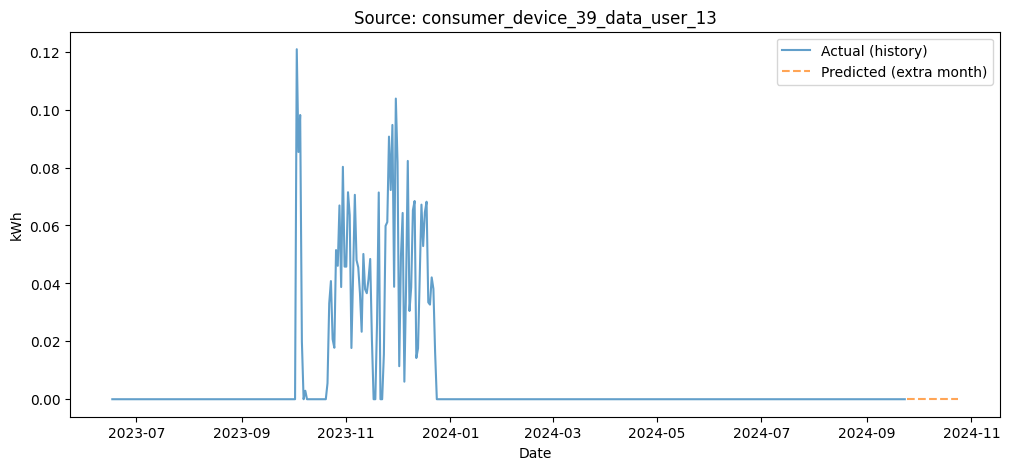

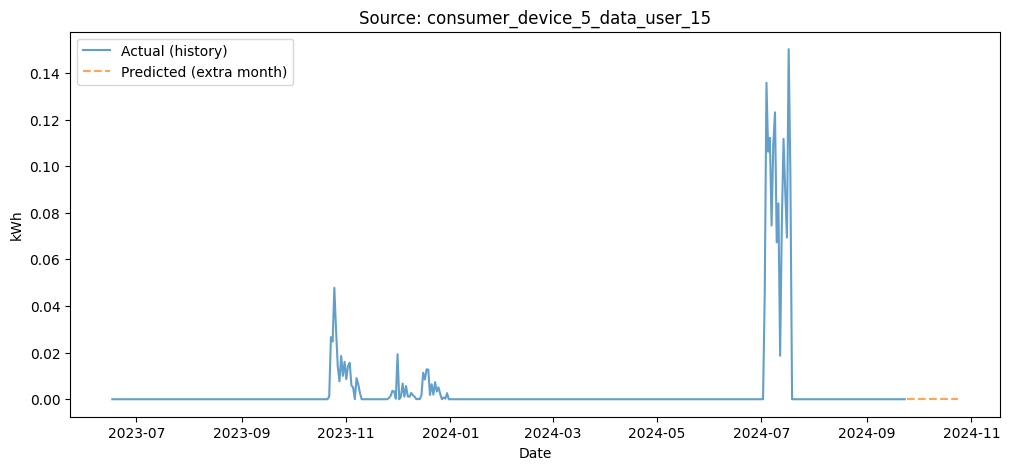

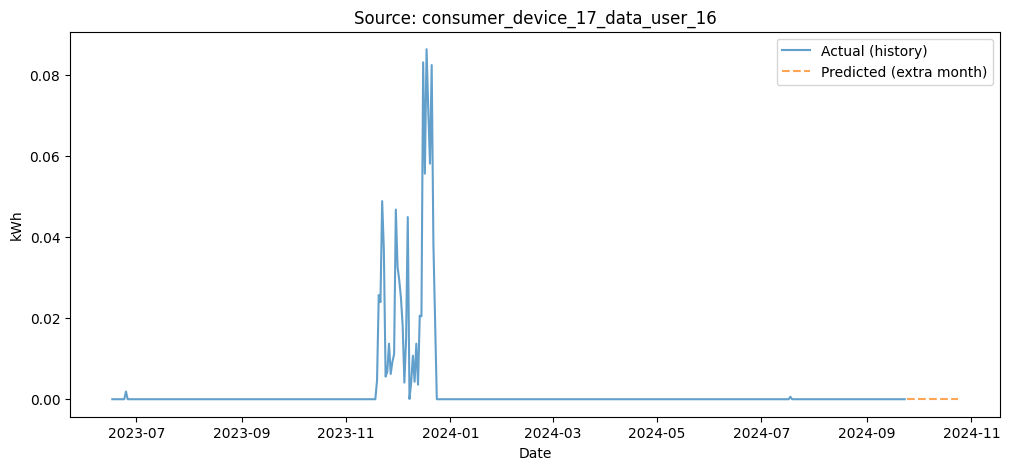

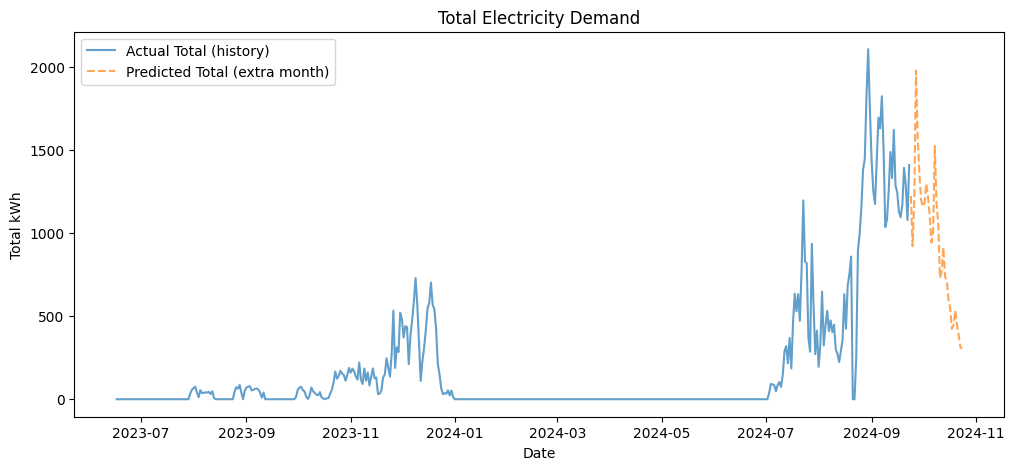

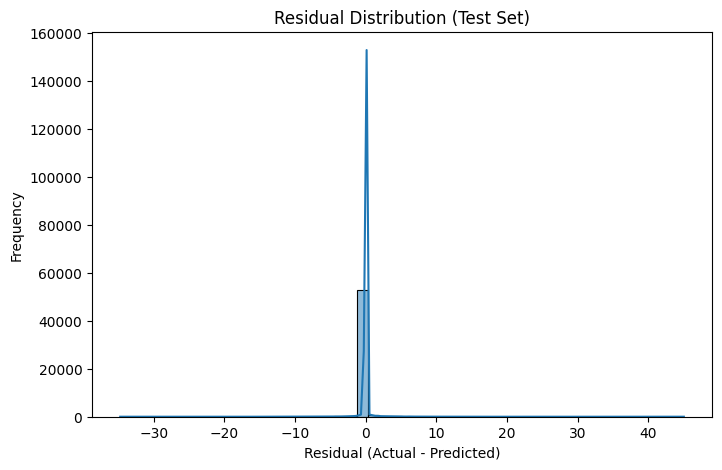

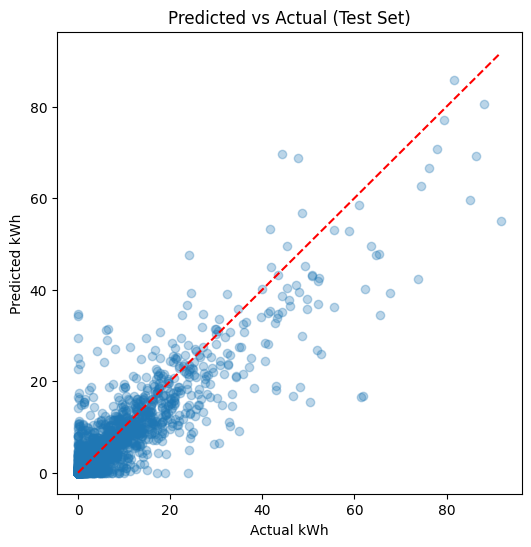

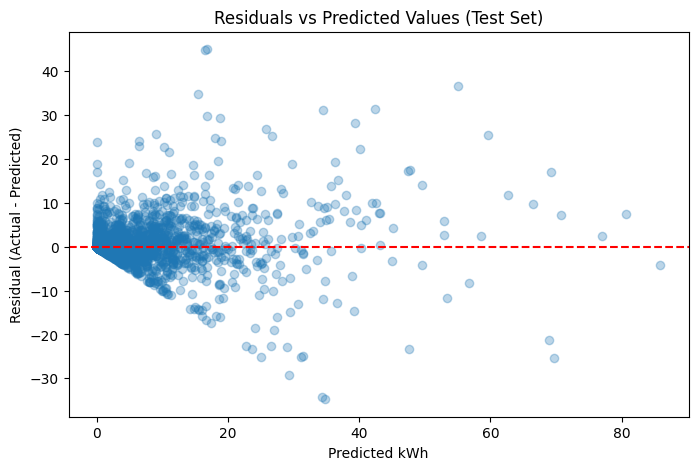

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Plot historical vs predictions for a few sources ---
sample_sources = np.random.choice(df["Source"].unique(), 3, replace=False)

for src in sample_sources:
    df_src = df[df["Source"] == src].copy()
    preds_src = preds_df[preds_df["Source"] == src].copy()
    
    plt.figure(figsize=(12,5))
    plt.plot(df_src["Date"], df_src["kwh"], label="Actual (history)", alpha=0.7)
    plt.plot(preds_src["Date"], preds_src["pred_kwh"], label="Predicted (extra month)", alpha=0.7, linestyle="--")
    plt.title(f"Source: {src}")
    plt.xlabel("Date"); plt.ylabel("kWh")
    plt.legend(); plt.show()

# --- Total demand (sum of all sources) ---
df_total = df.groupby("Date")["kwh"].sum().reset_index()
preds_total = preds_df.groupby("Date")["pred_kwh"].sum().reset_index()

plt.figure(figsize=(12,5))
plt.plot(df_total["Date"], df_total["kwh"], label="Actual Total (history)", alpha=0.7)
plt.plot(preds_total["Date"], preds_total["pred_kwh"], label="Predicted Total (extra month)", alpha=0.7, linestyle="--")
plt.title("Total Electricity Demand")
plt.xlabel("Date"); plt.ylabel("Total kWh")
plt.legend(); plt.show()

# ===================================================
# --- Residual Analysis (using train/test predictions) ---
# Compute residuals for test set
residuals = y_test - y_pred

# Residuals distribution
plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=50, kde=True)
plt.title("Residual Distribution (Test Set)")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Frequency")
plt.show()

# Scatter plot: Predicted vs Actual
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.3)
plt.plot([0, max(y_test)], [0, max(y_test)], "r--")  # perfect line
plt.xlabel("Actual kWh")
plt.ylabel("Predicted kWh")
plt.title("Predicted vs Actual (Test Set)")
plt.show()

# Residuals vs Predictions (check bias)
plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuals, alpha=0.3)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted kWh")
plt.ylabel("Residual (Actual - Predicted)")
plt.title("Residuals vs Predicted Values (Test Set)")
plt.show()


--------------------------------------

# Okey, so we keep that model. Let us do some more performance assesment: 

- Do random split (same as before) → for competition metrics.

- Do temporal split (last 30 days per source) → to simulate forecasting and allow plotting of actual vs predicted as a time series.

In [22]:
# --- Keep your existing feature engineering pipeline ---
# df, X, y, feature_cols, scaler are already prepared
# mlp model is already trained on RANDOM split

# =======================================================
# 1) Random Split (already done, used for Zindi scoring)
# X_train, X_test, y_train, y_test = ...

# =======================================================
# 2) Temporal Validation Split

df_sorted = df.sort_values(["Source", "Date"]).copy()

temporal_val = []
temporal_preds = []

for src in df_sorted["Source"].unique():
    src_data = df_sorted[df_sorted["Source"] == src].copy()
    
    if len(src_data) < 40:
        continue  # skip too short series
    
    # last 30 days = validation
    train_src = src_data.iloc[:-30]
    val_src = src_data.iloc[-30:]
    
    X_val = scaler.transform(val_src[feature_cols].values)
    y_val = val_src["kwh"].values
    y_hat = mlp.predict(X_val, verbose=0).flatten()
    y_hat = np.maximum(0, y_hat)
    
    temporal_val.append(val_src.assign(pred=y_hat))
    temporal_preds.append((y_val, y_hat))

temporal_val_df = pd.concat(temporal_val)




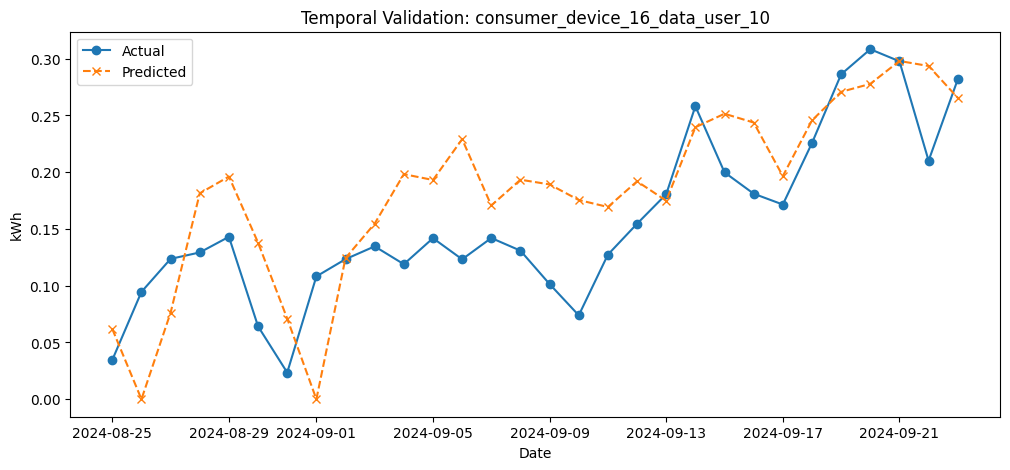

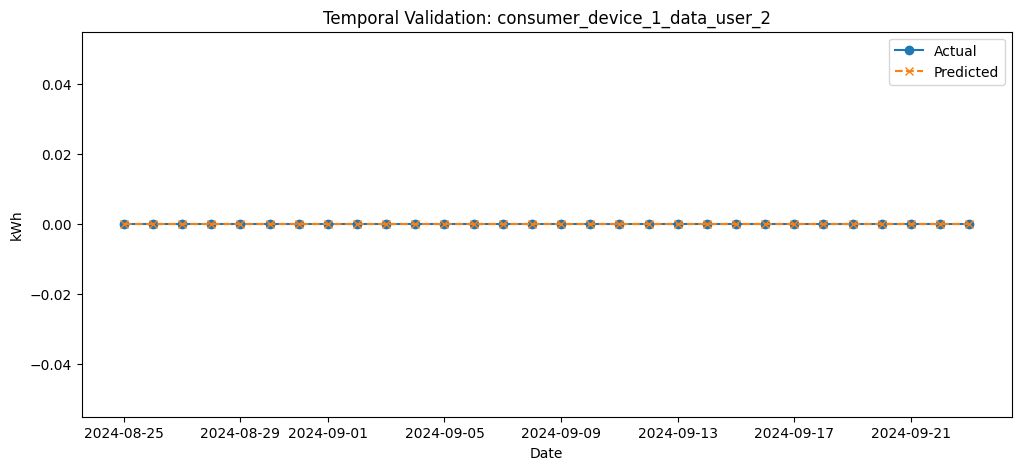

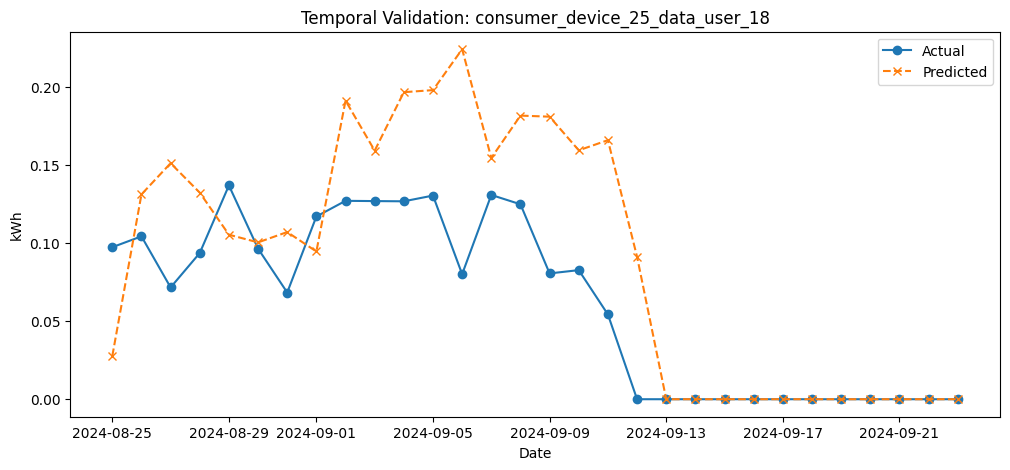

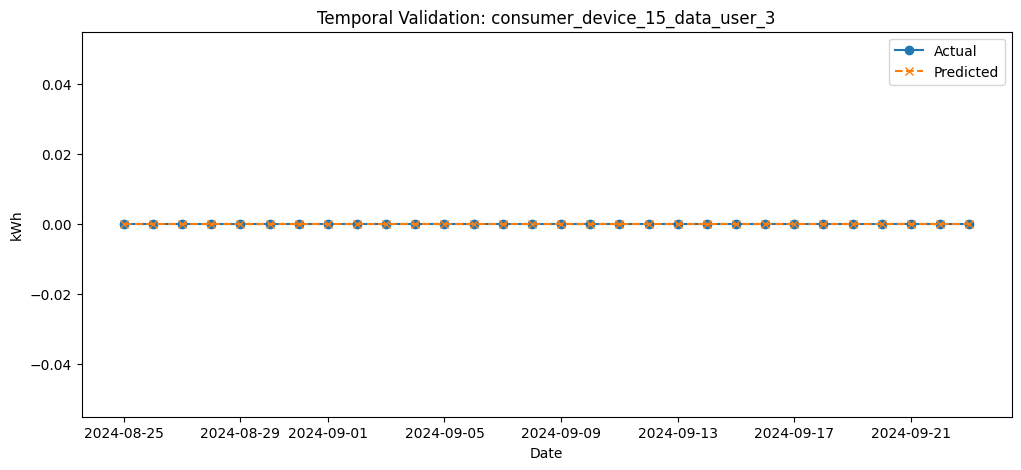

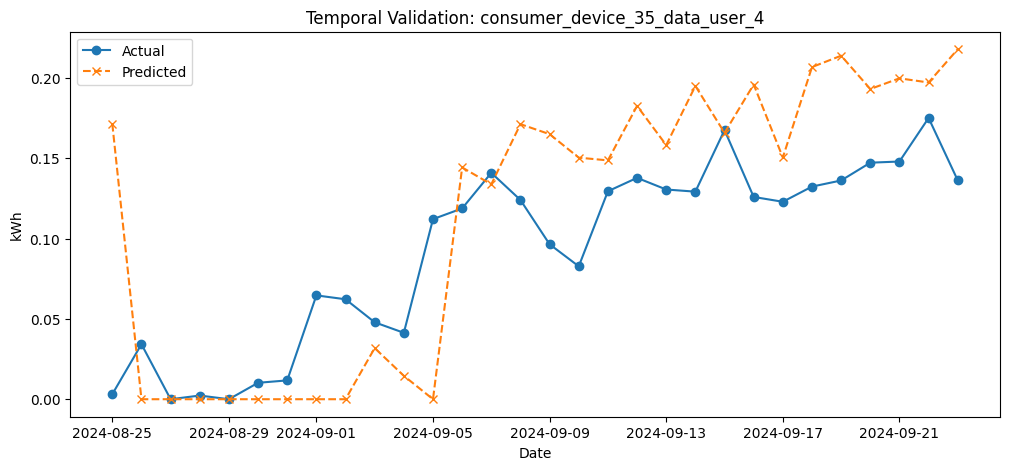

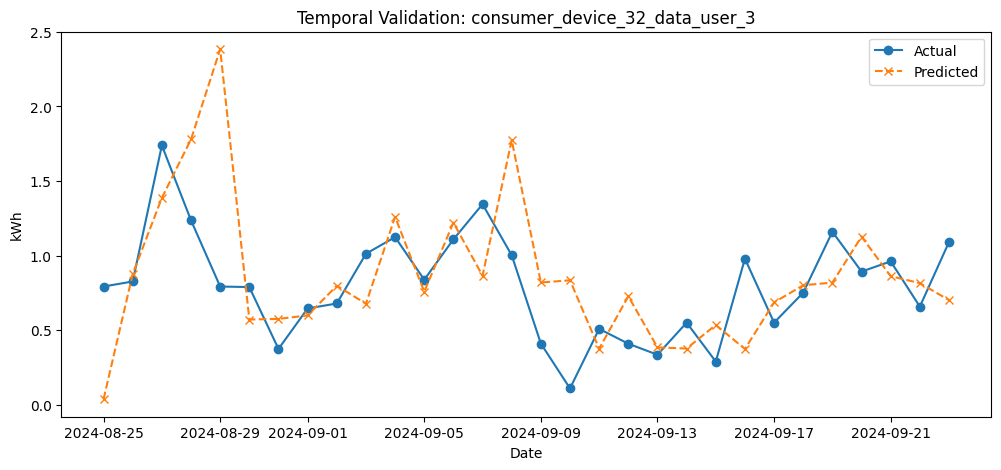

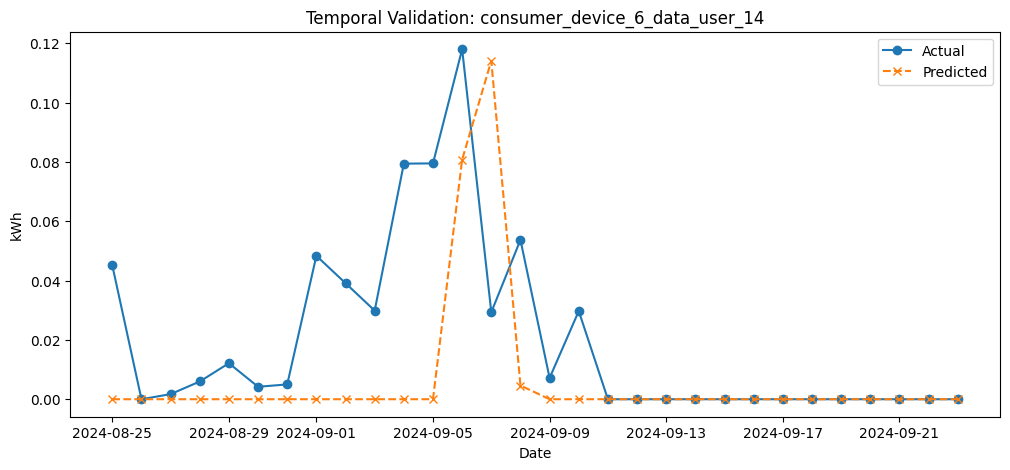

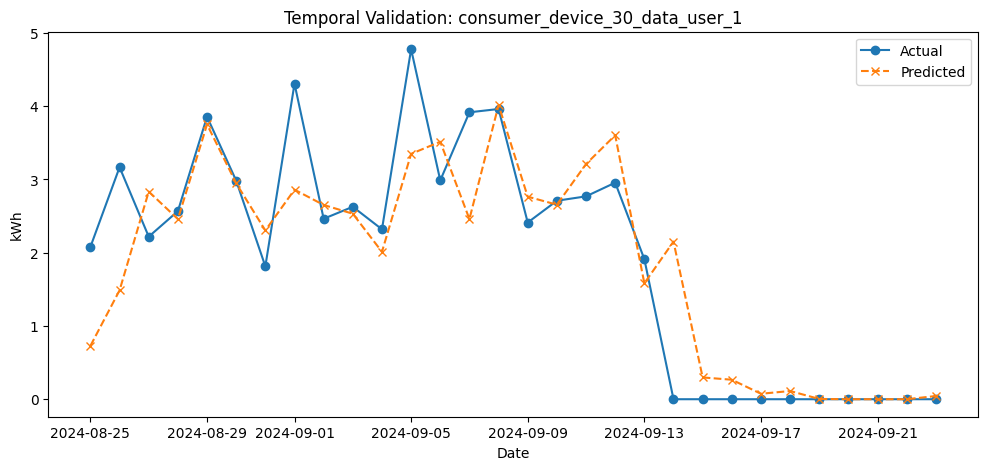

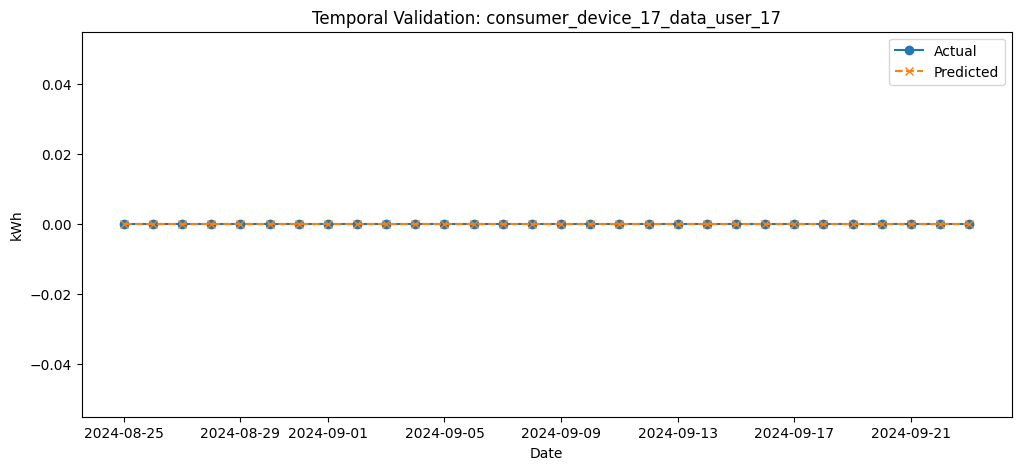

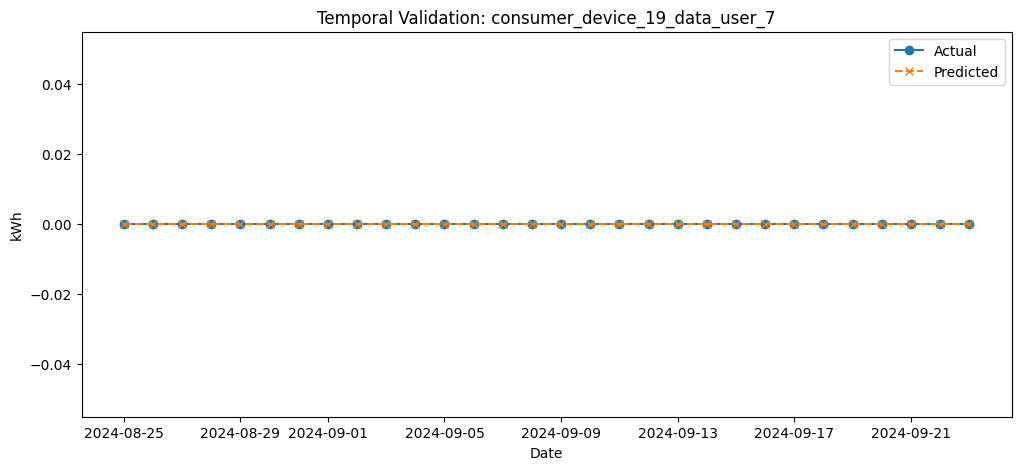

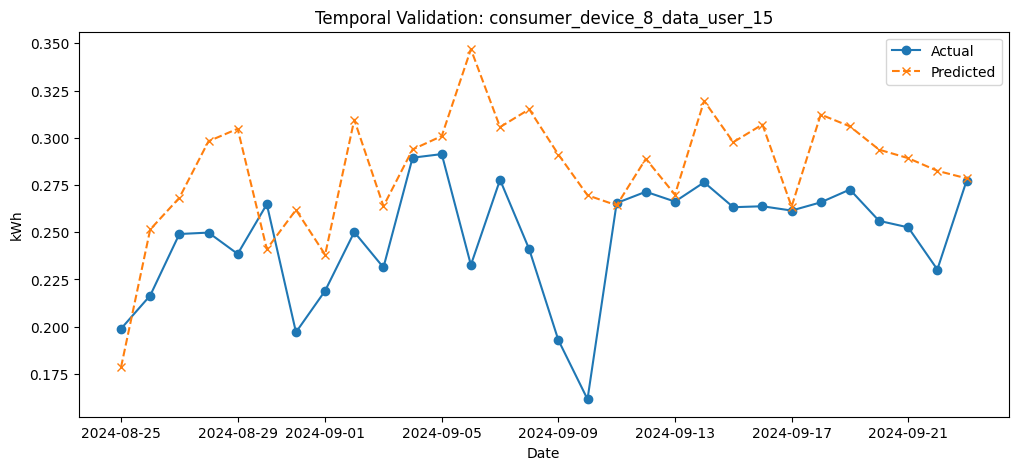

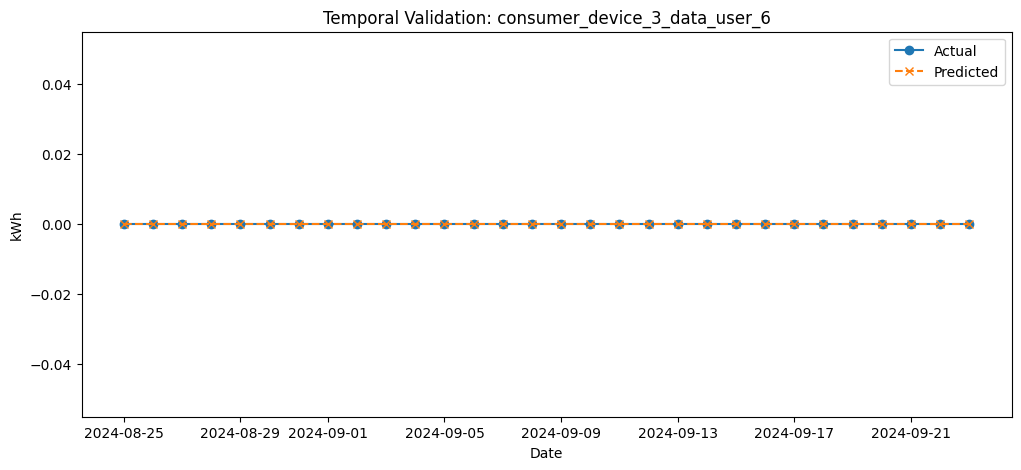

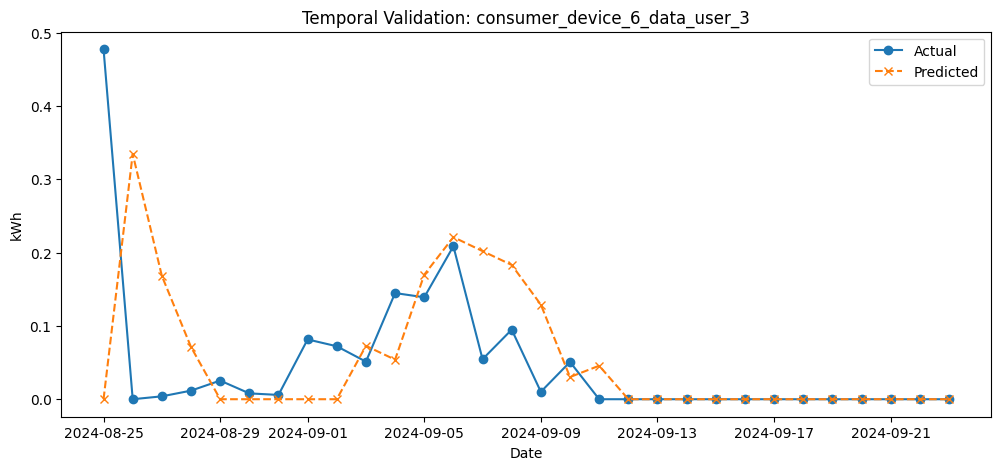

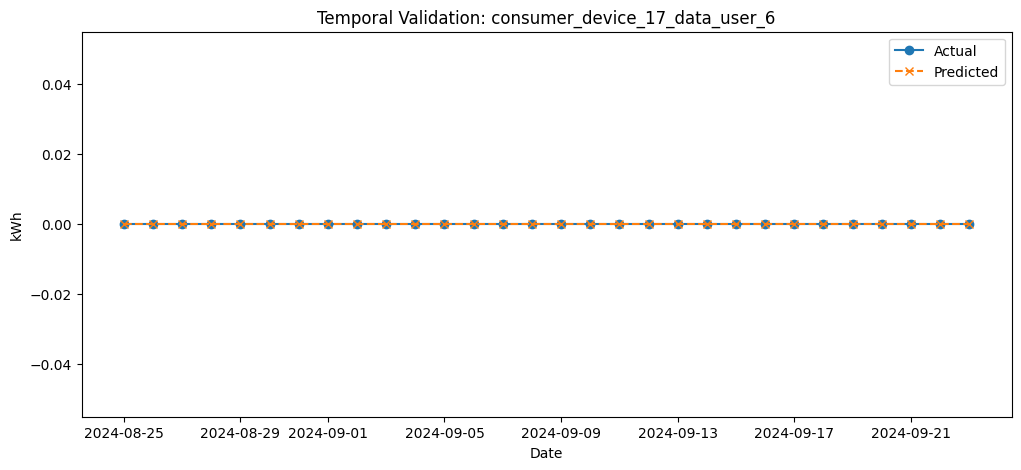

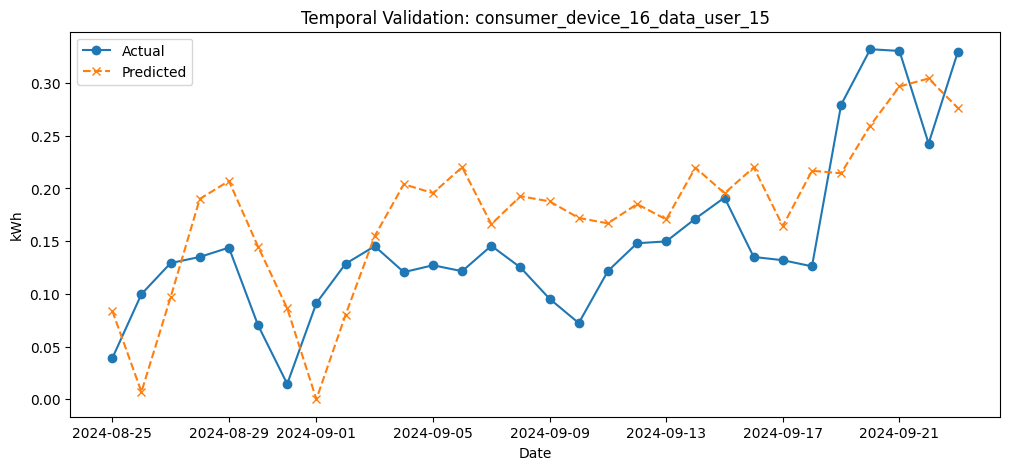

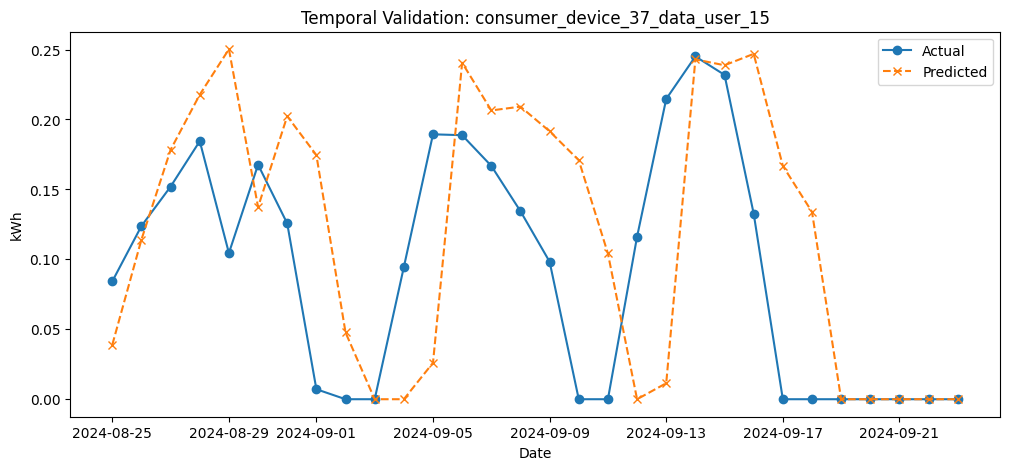

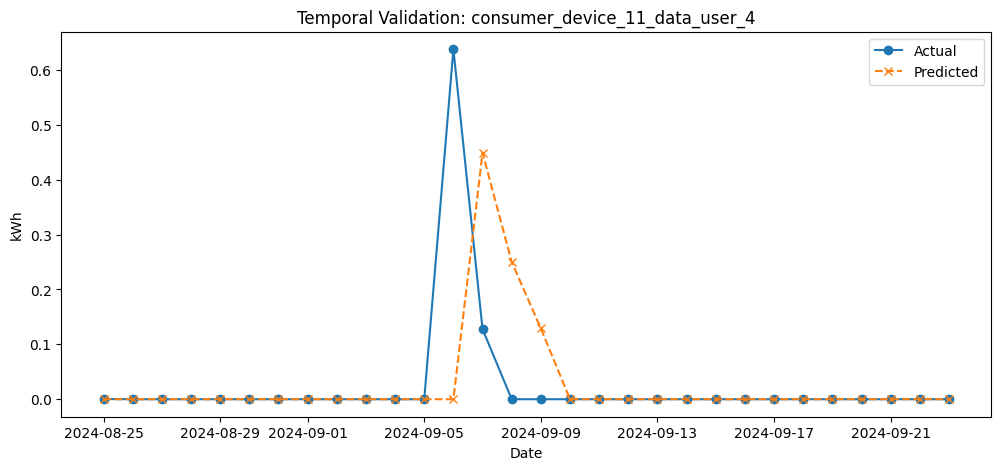

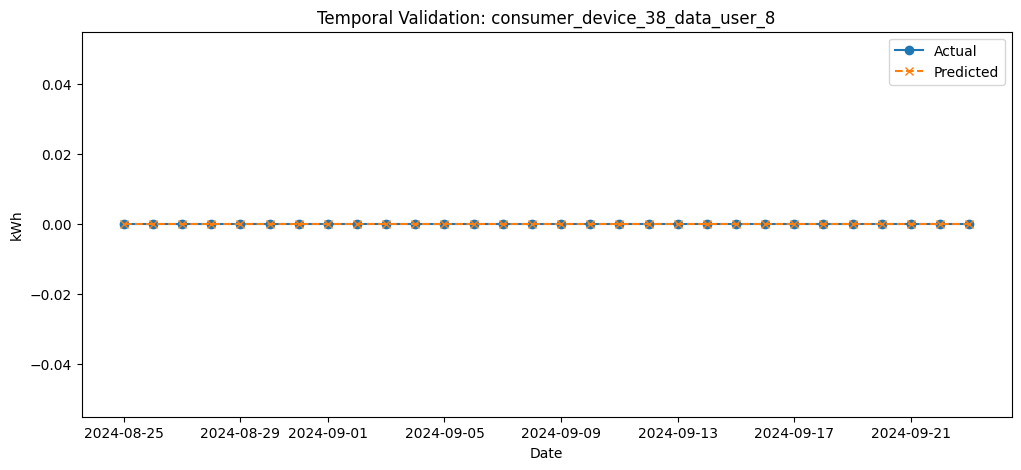

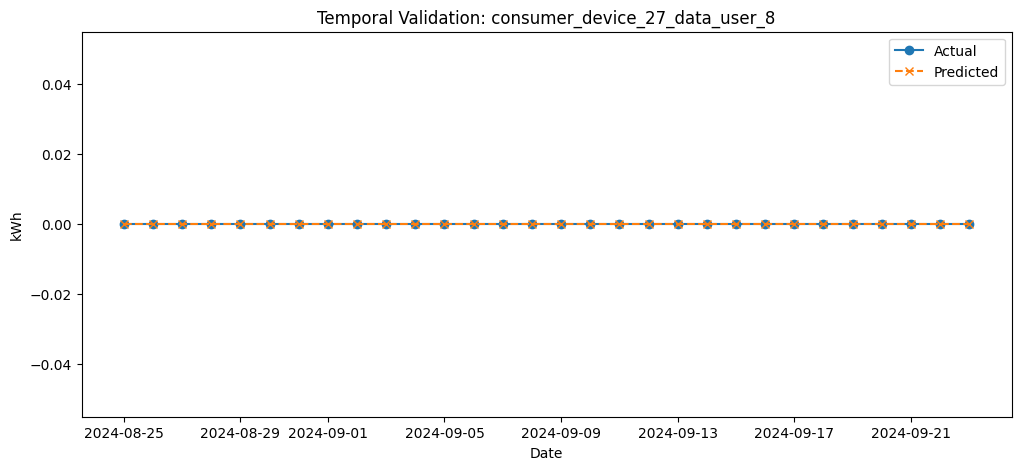

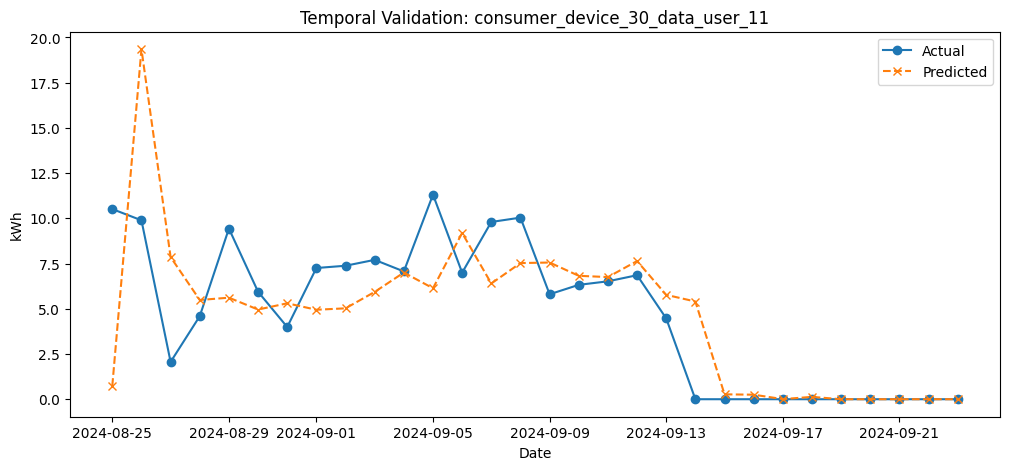

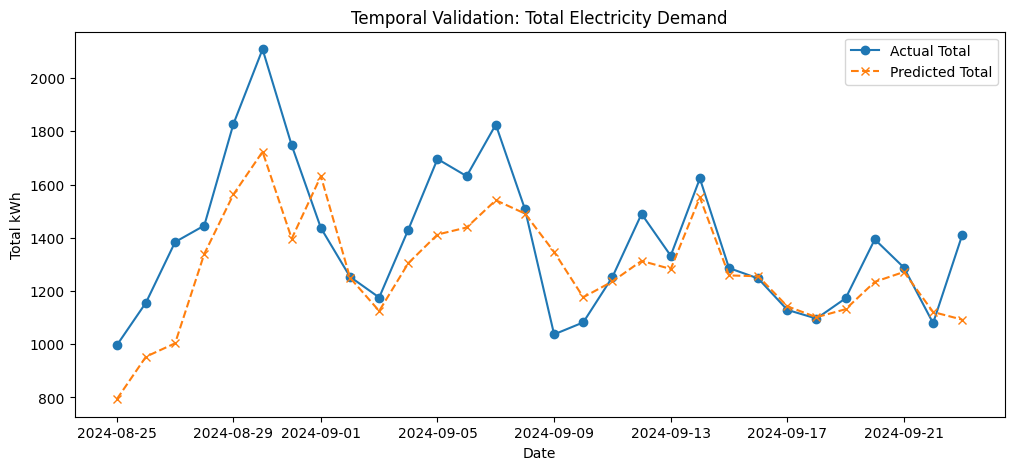

In [23]:
# =======================================================
# 3) Plots for temporal validation
sample_sources = np.random.choice(temporal_val_df["Source"].unique(), 20, replace=False)

for src in sample_sources:
    src_val = temporal_val_df[temporal_val_df["Source"] == src]
    plt.figure(figsize=(12,5))
    plt.plot(src_val["Date"], src_val["kwh"], label="Actual", marker="o")
    plt.plot(src_val["Date"], src_val["pred"], label="Predicted", marker="x", linestyle="--")
    plt.title(f"Temporal Validation: {src}")
    plt.xlabel("Date"); plt.ylabel("kWh")
    plt.legend(); plt.show()

# --- Total demand for validation period ---
val_total = temporal_val_df.groupby("Date")[["kwh","pred"]].sum().reset_index()

plt.figure(figsize=(12,5))
plt.plot(val_total["Date"], val_total["kwh"], label="Actual Total", marker="o")
plt.plot(val_total["Date"], val_total["pred"], label="Predicted Total", marker="x", linestyle="--")
plt.title("Temporal Validation: Total Electricity Demand")
plt.xlabel("Date"); plt.ylabel("Total kWh")
plt.legend(); plt.show()

